<a href="https://colab.research.google.com/github/pratyushghosh/CS4243_Mini_Project/blob/main/Baseline_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf /content/frames
!rm /content/Combined_Frames.zip

In [2]:
import pathlib
import PIL
from google.colab import drive
import zipfile
import os.path
from os import path
import gdown
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Extract frames from zip
if(not path.exists("/content/frames")):
    src_url = 'https://drive.google.com/uc?id=1QI6qIIV0ZMy6ytAlHYTMOKQBvEuZLtJM'
    gdown.download(src_url, 'Combined_Frames.zip')
    zip_ref = zipfile.ZipFile("/content/Combined_Frames.zip", 'r')
    zip_ref.extractall("/content/frames")
    zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1QI6qIIV0ZMy6ytAlHYTMOKQBvEuZLtJM
To: /content/Combined_Frames.zip
100%|██████████| 419M/419M [00:02<00:00, 197MB/s]


In [4]:
frames_dir = pathlib.Path("/content/frames/Combined_Frames")

# Testing that extraction was successful
image_count = len(list(frames_dir.glob('*/*.jpg')))
print(image_count)

# carrying = list(frames_dir.glob('Carrying/*'))
# PIL.Image.open(str(carrying[0]))

1335


# Separating Testing Frames

In [5]:
class_names = [fname for fname in os.listdir(frames_dir)]
frame_names = {}
all_frames_dir = "/content/frames/Combined_Frames"
testing_frames_dir = "/content/frames/testing_frames"

for class_name in class_names:
  os.makedirs(testing_frames_dir + "/" + class_name)

for class_name in class_names:
  current_folder = all_frames_dir + "/" + class_name
  frame_names[class_name] = [fname for fname in os.listdir(current_folder)]

In [6]:
def move_test_frames(frames, class_name):
  for frame in frames:
    curr = f"{all_frames_dir}/{class_name}/{frame}"
    new = f"{testing_frames_dir}/{class_name}/{frame}"
    os.rename(curr, new)

In [7]:
for class_name, class_frame_names in frame_names.items():
  curr_dir = os.path.join(all_frames_dir, class_name)
  print("total num frames:", len([name for name in os.listdir(curr_dir) if os.path.isfile(os.path.join(curr_dir, name))]))

  random.shuffle(class_frame_names)
  num_frames_to_move = int(np.ceil(len(class_frame_names) * 0.1))
  frames_to_move = class_frame_names[:num_frames_to_move]
  move_test_frames(frames_to_move, class_name)

total num frames: 445
total num frames: 445
total num frames: 445


In [8]:
# Check that files have been moved successfully
for class_name in class_names:
  print(class_name)
  curr_all_dir = os.path.join(all_frames_dir, class_name)
  curr_testing_dir = os.path.join(testing_frames_dir, class_name)
  print(len([name for name in os.listdir(curr_all_dir) if os.path.isfile(os.path.join(curr_all_dir, name))]))
  print(len([name for name in os.listdir(curr_testing_dir) if os.path.isfile(os.path.join(curr_testing_dir, name))]))
  print('\n')

Threat
400
45


Normal
400
45


Carrying
400
45




# Training & Validation

In [9]:
# Set up dataset
batch_size = 30
img_height = 120
img_width = 120
seed = 123

training_set = tf.keras.utils.image_dataset_from_directory(
  frames_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_set = tf.keras.utils.image_dataset_from_directory(
  frames_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1200 files belonging to 3 classes.
Using 960 files for training.
Found 1200 files belonging to 3 classes.
Using 240 files for validation.


In [10]:
class_names = training_set.class_names
print(class_names)

['Carrying', 'Normal', 'Threat']


In [11]:
# Buffered pre-fetching
AUTOTUNE = tf.data.AUTOTUNE

training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Augment frames
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.1)
])

In [13]:
num_classes = 3

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # normalize frames
  # layers.Conv2D(16, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Conv2D(64, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                      

In [15]:
epochs = 20

history = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=epochs
)

Epoch 1/20
32/32 [==============================] - 33s 532ms/step - loss: 2.3904 - accuracy: 0.3719 - val_loss: 1.0574 - val_accuracy: 0.4417
Epoch 2/20
32/32 [==============================] - 15s 465ms/step - loss: 1.0353 - accuracy: 0.4667 - val_loss: 0.9781 - val_accuracy: 0.5333
Epoch 3/20
32/32 [==============================] - 15s 463ms/step - loss: 0.9688 - accuracy: 0.5469 - val_loss: 0.9583 - val_accuracy: 0.4708
Epoch 4/20
32/32 [==============================] - 15s 461ms/step - loss: 0.9238 - accuracy: 0.5479 - val_loss: 0.9144 - val_accuracy: 0.5667
Epoch 5/20
32/32 [==============================] - 15s 461ms/step - loss: 0.8448 - accuracy: 0.6240 - val_loss: 0.8735 - val_accuracy: 0.5667
Epoch 6/20
32/32 [==============================] - 17s 530ms/step - loss: 0.8321 - accuracy: 0.6260 - val_loss: 0.8162 - val_accuracy: 0.5833
Epoch 7/20
32/32 [==============================] - 15s 461ms/step - loss: 0.7778 - accuracy: 0.6417 - val_loss: 0.8434 - val_accuracy: 0.6042

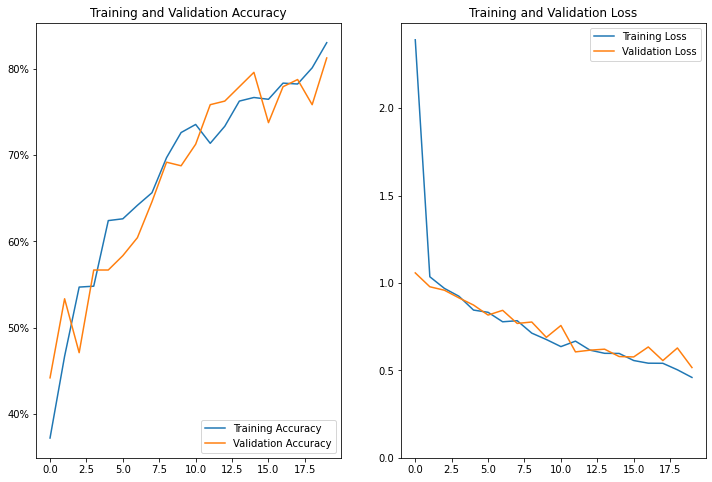

In [16]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
# plt.gca().set_ylim(bottom=0)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.gca().set_ylim(bottom=0)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing

In [17]:
test_dir = pathlib.Path("/content/frames/testing_frames")
# test_set = tf.keras.utils.image_dataset_from_directory(test_dir)
test_set = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width))
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

Found 135 files belonging to 3 classes.


In [18]:
def get_actual_predicted_labels(dataset): 
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of threat recognition for ' + ds_type)
  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('Actual Label')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

5/5 [==============================] - 1s 94ms/step


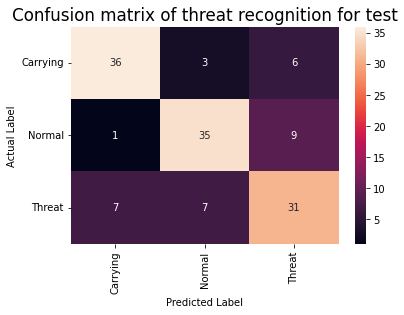

In [20]:
model.evaluate(test_set, return_dict=True)
actual, predicted = get_actual_predicted_labels(test_set)
plot_confusion_matrix(actual, predicted, class_names, 'test')